#### Notebook setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import time
import warnings
import os, sys
from copy import deepcopy
from types import SimpleNamespace
from pprint import pprint as print

import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm.auto import tqdm, trange

from multirotor.helpers import control_allocation_matrix, DataLog
from multirotor.vehicle import MotorParams, VehicleParams, PropellerParams, SimulationParams, BatteryParams
from multirotor.controller import (
    PosController, VelController,
    AttController, RateController,
    AltController, AltRateController,
    Controller
)
from multirotor.simulation import Multirotor, Propeller, Motor, Battery
from multirotor.coords import body_to_inertial, inertial_to_body, direction_cosine_matrix, euler_to_angular_rate
from multirotor.env import SpeedsMultirotorEnv, DynamicsMultirotorEnv
from multirotor.trajectories import Trajectory
from multirotor.visualize import plot_datalog

In [2]:
import logging

logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True

In [3]:
# Plotting/display parameters
# https://stackoverflow.com/a/21009774/4591810
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE, titlesize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


### Parameters

In [4]:
# Tarot T18 params
bp = BatteryParams(max_voltage=25.2)
mp = MotorParams(
    moment_of_inertia=5e-5,
    # resistance=0.27,
    resistance=0.081,
    k_emf=0.0265,
    # k_motor=0.0932,
    speed_voltage_scaling= 0.0325,
    # speed_voltage_scaling= 0.025,
    max_current=38.
)
pp = PropellerParams(
    moment_of_inertia=1.85e-6,
    use_thrust_constant=True,
    k_thrust=9.8419e-05, # 18-inch propeller
    # k_thrust=5.28847e-05, # 15 inch propeller
    k_drag=1.8503e-06, # 18-inch propeller
    # k_drag=1.34545e-06, # 15-inch propeller
    motor=mp #try motor = none
)
vp = VehicleParams(
    propellers=[pp] * 8,
    battery=bp,
    # angles in 45 deg increments, rotated to align with
    # model setup in gazebo sim (not part of this repo)
    #originally was 0.375
    # angles=np.linspace(0, -2*np.pi, num=8, endpoint=False) + 0.5*np.pi,
    angles=np.array([0.5, 1.5, 0.25, 1.75, 0.75, 1.25, 1, 0])*np.pi,
    distances=np.ones(8) * 0.635,
    # clockwise=[-1,1,-1,1,-1,1,-1,1],
    # clockwise=[1,-1,1,-1,1,-1,1,-1],
    clockwise=[1,1,-1,-1,-1,-1,1,1],
    mass=10.66,
    inertia_matrix=np.asarray([
        [0.2206, 0, 0],
        [0, 0.2206, 0.],
        [0, 0, 0.4238]
    ])
)
sp = SimulationParams(dt=0.0025, g=9.81) #dt should be 0.0025

### PID Controller

This section explains how a PID controller is constructed. This is a cascaded PID architecture. See `Controller` docs
for more details.

In [5]:
# From PID parameters file
def get_controller(m: Multirotor, max_velocity=5., max_acceleration=3.):
    assert m.simulation.dt <= 0.1, 'Simulation time step too large.'
    pos = PosController(
        1.0, 0., 0., 1., vehicle=m,
        max_velocity=max_velocity, max_acceleration=max_acceleration,
        square_root_scaling=False, leashing=False
    )
    vel = VelController(
        2.0, 1.0, 0.5,
        max_err_i=max_acceleration,
        max_tilt=np.pi/12,
        vehicle=m)
    att = AttController(
        [2.6875, 4.5, 4.5],
        0, 0.,
        max_err_i=1.,
        vehicle=m)
    rat = RateController(
        [4., 4., 4.],
        0, 0,
        max_err_i=0.5,
        max_acceleration=1.,
        vehicle=m)
    alt = AltController(
        1, 0, 0,
        max_err_i=1, vehicle=m,
        max_velocity=max_velocity)
    alt_rate = AltRateController(
        5, 0, 0,
        max_err_i=1, vehicle=m)
    ctrl = Controller(
        pos, vel, att, rat, alt, alt_rate,
        period_p=0.1, period_a=0.01, period_z=0.1
    )
    return ctrl

### Parameter search

Using `optuna` to search over the space of PID controller parameters.

In [6]:
from multirotor.optimize import optimize, DEFAULTS
print(DEFAULTS)

Namespace(bounding_box=20, max_velocity=5, max_acceleration=2.5, max_tilt=0.2617993877991494, leashing=True, sqrt_scaling=True, use_yaw=True, num_sims=10, scurve=False, max_err_i_attitude=0.1, max_err_i_rate=0.1)


In [25]:
# search over parameter space
study = optimize(vp, sp, ntrials=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Simulation

Combining `Multiotor` and `Controller` to run a simulation. First, defining waypoints:

In [26]:
# NASA flight test
# wp = np.asarray([
#     [0.0, 0.0, 30.0],
#     [164.0146725649829, -0.019177722744643688, 30.0],
#     [165.6418055187678, 111.5351051245816, 30.0],
#     [127.3337449710234, 165.73576059611514, 30.0],
#     [-187.28170707810204, 170.33217775914818, 45.0],
#     [-192.03130502498243, 106.30660058604553, 45.0],
#     [115.89920266153058, 100.8644210617058, 30.0],
#     [114.81859536317643, 26.80923518165946, 30.0],
#     [-21.459931490011513, 32.60508110653609, 30.0]
# ])
wp = np.asarray([
    [0,10,0],
    [10,10,0],
    [10,0,0],
    [0,0,0]
])

Then, defining a disturbance (for example, wind). The disturabance function takes time, `Multirotor`, and returns the forces in the *body frame* of the vehicle.

In [27]:
def wind(t, m):
    w_inertial = np.asarray([5 * np.sin(t * 2 * np.pi / 4000), 0, 0])
    dcm = direction_cosine_matrix(*m.orientation)
    return inertial_to_body(w_inertial, dcm), 0

In [28]:
def addNoise(val, std):
    noise = np.random.normal(0, std)
    val += noise

In [45]:
# Defining the run simulation function which illustrates all the
# steps that go into each step of the simulation.
# 
def run_sim(env, traj, ctrl, steps=60_000, disturbance=None):

    log = DataLog(env.vehicle, ctrl,
                  other_vars=('currents', 'voltages'))

    disturb_force, disturb_torque = 0., 0
    for i, (pos, feed_forward_vel) in tqdm(
        enumerate(traj), leave=False, total=steps
    ):
        if i==steps: break
        # Generate reference for controller
        ref = np.asarray([*pos, 0.])
        # Get prescribed dynamics for system as thrust and torques
        dynamics = ctrl.step(ref, feed_forward_velocity=feed_forward_vel)
        thrust, torques = dynamics[0], dynamics[1:]
        # Allocate control: Convert dynamics into motor rad/s
        action = env.vehicle.allocate_control(thrust, torques)
        # get any disturbances
        if disturbance is not None:
            disturb_force, disturb_torque = disturbance(i, env.vehicle)
        # Send speeds to environment
        state, *_ = env.step(
            action, disturb_forces=disturb_force, disturb_torques=disturb_torque
        )
        alloc_errs = np.asarray([thrust, *torques]) - env.vehicle.alloc @ action**2

        for i in range(3):
            env.vehicle.state[i] += np.random.normal(0, 0.05)
            state[i] += np.random.normal(0, 0.05)
        for i in range(3):
            env.vehicle.state[i+6] += np.random.normal(0, 0.04)
            state[i+6] += np.random.normal(0, 0.04)

        toData = np.concatenate(([i], action, state))
        with open('simData.csv', 'a') as file:
            np.savetxt(file, toData.reshape(1, -1), delimiter=',', fmt='%.5f') #i, 8 motor commands, 12 state array (pos, vel, angular pos, angular vel)

        log.log(currents=[p.motor.current for p in env.vehicle.propellers],
                voltages=[p.motor.voltage for p in env.vehicle.propellers])

        if np.any(np.abs(env.vehicle.orientation[:2]) > np.pi/6): break

    log.done_logging()
    return log

In [46]:
env = SpeedsMultirotorEnv(vehicle=Multirotor(vp, sp)) # step() takes speed signals
traj = Trajectory(env.vehicle, wp, proximity=2, resolution=10)
ctrl = get_controller(env.vehicle, max_velocity=3.)
ctrl.set_params(params=study.best_params)
env.reset()
ctrl.reset()
log = run_sim(env, traj, ctrl, steps=60_000, disturbance=wind)

  0%|          | 0/60000 [00:00<?, ?it/s]

{'pos': <Axes: title={'center': 'Position and Orientation'}, ylabel='Orientation /deg'>,
 'vel': <Axes: title={'center': 'Velocities'}>,
 'ctrl': <Axes: ylabel='Torque /Nm'>,
 'traj': <Axes: title={'center': 'XY positions /m'}, xlabel='X /m', ylabel='Y /m'>}

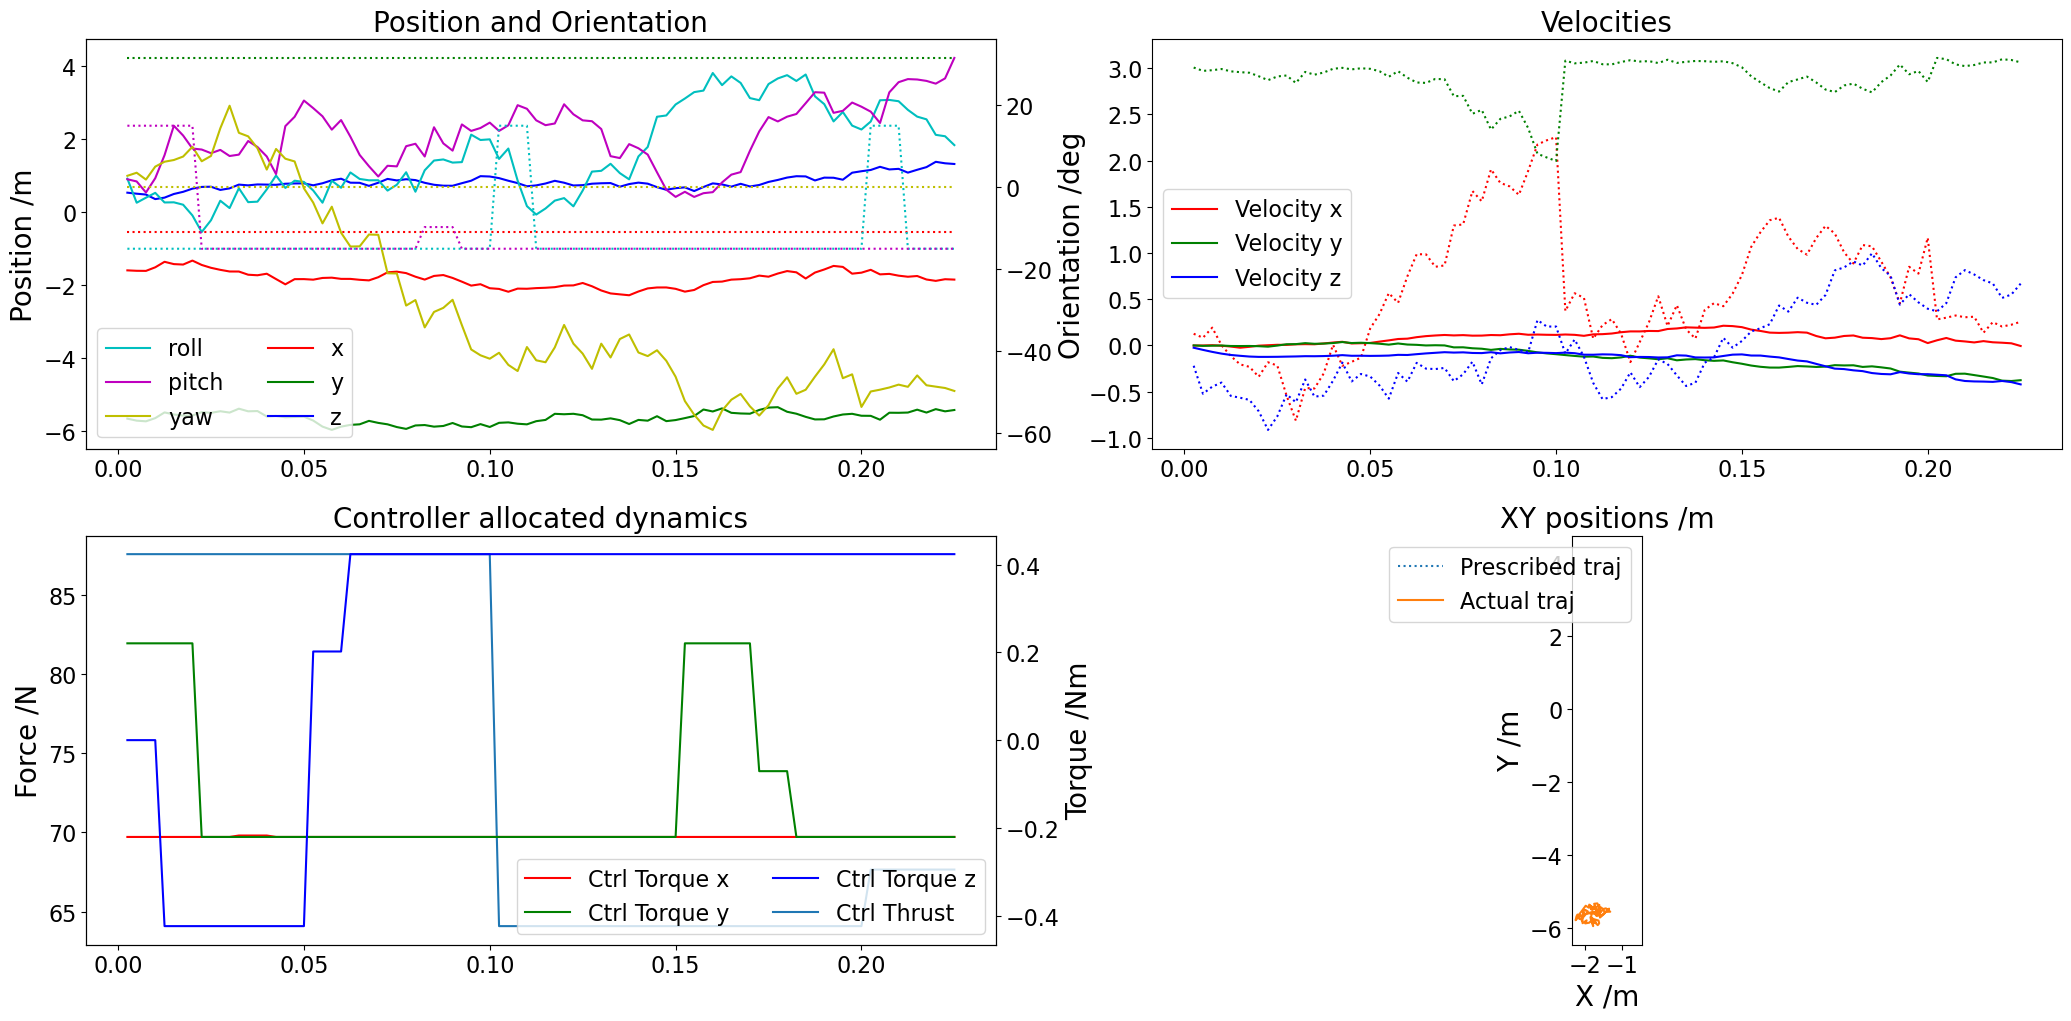

In [47]:
# PLot positions, velocities, prescribed dynamics
plot_datalog(log)

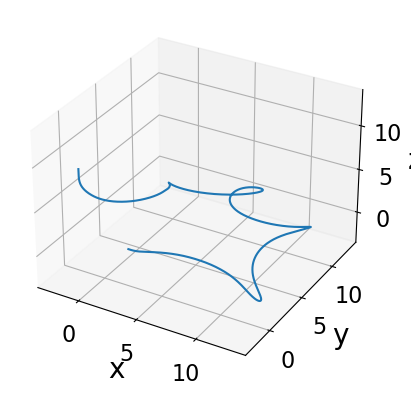

In [24]:
# 3D plot of trajectory
# %matplotlib notebook
fig = plt.figure()
xlim = ylim = zlim = (np.min(log.position), np.max(log.position))
ax = fig.add_subplot(projection='3d', xlim=xlim, ylim=ylim, zlim=zlim)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.plot(log.x, log.y, log.z)

In [43]:
with open("simData.csv", 'w') as file:
    pass